In [6]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
%matplotlib inline

In [9]:
#read data 
df = pd.read_csv('combined.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 30 columns):
Unnamed: 0              49636 non-null int64
ACCIDENTDATE            49636 non-null object
AOTACTUALMILEPOINT      49636 non-null object
AOTROUTE                49299 non-null object
Animal                  49636 non-null object
CITYORTOWN              49505 non-null object
DIROFCOLLI              37121 non-null object
DayNight                49636 non-null object
HOWMAPPED               49110 non-null object
INTERSECTIONWITH        40181 non-null object
Impairment              49636 non-null object
InjuryType              49636 non-null object
Involving               49636 non-null object
LAT_DD                  49110 non-null float64
LOCALID                 39326 non-null float64
LOC_ERROR               49636 non-null object
LONG_DD                 49110 non-null float64
LRSNUMBER               49636 non-null object
NonReportableAddress    49636 non-null object
REPORTINGAGENCY

In [20]:
# Preprocess data
AOTRoute = pd.Series(np.where(((df['AOTROUTE'] != 'US-7')&(df['AOTROUTE'] != 'I-89')&
                            (df['AOTROUTE'] != 'I-91')&(df['AOTROUTE'] != 'US-2')&
                            (df['AOTROUTE'] != 'US-5')&(df['AOTROUTE'] != 'VT-15')&
                            (df['AOTROUTE'] != 'VT-100')&(df['AOTROUTE'] != 'VT-9')&
                            (df['AOTROUTE'] != 'VT-2A')&(df['AOTROUTE'] != 'US-4')),'Other',df.AOTROUTE))
AOTRoute = pd.get_dummies(AOTRoute)

# get dummies for animal --> get "none" column for yes/no
animal = pd.get_dummies(df['Animal'])['None/Other']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
animal = pd.Series(np.where(np.array(animal)==0,1,0))

city_town = pd.Series(np.where(((df['CITYORTOWN'] != 'Burlington')&(df['CITYORTOWN'] != 'Brattleboro')&
                            (df['CITYORTOWN'] != 'South Burlington')&(df['CITYORTOWN'] != 'Essex')&
                            (df['CITYORTOWN'] != 'Bennington')&(df['CITYORTOWN'] != 'Williston')&
                            (df['CITYORTOWN'] != 'Colchester')&(df['CITYORTOWN'] != 'Springfield')&
                            (df['CITYORTOWN'] != 'Hartford')&(df['CITYORTOWN'] != 'Milton')),'Other',df.CITYORTOWN))
city_town = pd.get_dummies(city_town)

# DayNight --> save "night" case only as yes/no
night=pd.get_dummies(df['DayNight'])['Night']

# Impairment --> get "none" column for yes/no
impairment=pd.get_dummies(df['Impairment'])['None']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
impairment = pd.Series(np.where(np.array(impairment)==0,1,0))

# get dummies for Involving
involving = pd.get_dummies(df['Involving'])
# remove "none" column which is the null case
involving = involving.drop(columns = ['None'])

# Get dummies for road condition
roadcondition = pd.get_dummies(df['RoadCondition'])
# drop "none" column which is the null case, unreported situations, and the surface condition; will add in later
roadcondition = roadcondition.drop(columns=['None', 'Other - Explain in Narrative', 'Not reported', 'Unknown',
                                            'Road Surface Condition(wet, icy, snow, slush, etc)'])

# get dummies for surface condition
surfacecondition = pd.get_dummies(df['SurfaceCondition'])
# drop "dry" column which is the null case along with unreported situations
surfacecondition = surfacecondition.drop(columns=['Dry', 'Not Reported', 'Other - Explain in Narrative', 'Unknown'])

# get dummies for weather
weather = pd.get_dummies(df['Weather'])
# drop "clear" column which is the null case along with unreported situations
weather = weather.drop(columns=['Clear', 'Unknown'])

# get accident dates
datetime = df['ACCIDENTDATE']
months = '' # new string
# use loop to extract month from date string
for i in range(len(datetime)):
    match = re.search(r'\d{4}-\d{2}-\d{2}', datetime[i]).group()
    months += match[5:7] + ','
# remove last extraneous comma from loop
months = months[:-1]
# split comma separated string
months = months.split(",")
# convert to DataFrame
months = pd.Series(months)

# determine season
seasons = ""
for i in range(len(months)):
    if months[i]=='12':
        seasons += 'Winter' + ','
    if months[i]=='01':
        seasons += 'Winter' + ','
    if months[i]=='02':
        seasons += 'Winter' + ','
    if months[i]=='03':
        seasons += 'Spring' + ','
    if months[i]=='04':
        seasons += 'Spring' + ','
    if months[i]=='05':
        seasons += 'Spring' + ','
    if months[i]=='06':
        seasons += 'Summer' + ','
    if months[i]=='07':
        seasons += 'Summer' + ','
    if months[i]=='08':
        seasons += 'Summer' + ','
    if months[i]=='09':
        seasons += 'Fall' + ','
    if months[i]=='10':
        seasons += 'Fall' + ','
    if months[i]=='11':
        seasons += 'Fall' + ','
# remove last extraneous comma from loop
seasons = seasons[:-1]
# split comma separated string
seasons = seasons.split(",")
# convert to DataFrame
seasons = pd.Series(seasons)
seasons = pd.get_dummies(seasons)

injury = df['InjuryType'].copy()

for i in range(len(injury)):
    if injury.loc[i] == 'Property Damage Only':
        injury.loc[i] = 0
    else:
        injury.loc[i] = 1

# Build data frame for RF
rf_df = pd.concat([animal, night, impairment], axis=1)
rf_df.columns=['Animal', 'Night', 'Impairment']
rf_df = pd.concat([rf_df, AOTRoute, city_town, involving, roadcondition, surfacecondition, weather, seasons,injury],
                   axis=1, sort=False)

rf_df.rename(columns={'InjuryType':'injury'},  inplace=True)
rf_df.head()

,Animal,Night,Impairment,I-89,I-91,Other,US-2,US-4,US-5,US-7,...,Wet,Cloudy,Freezing Precipitation,Rain,Wind,Fall,Spring,Summer,Winter,injury
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
2,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [21]:
rf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 52 columns):
Animal                                                      49636 non-null int64
Night                                                       49636 non-null uint8
Impairment                                                  49636 non-null int64
I-89                                                        49636 non-null uint8
I-91                                                        49636 non-null uint8
Other                                                       49636 non-null uint8
US-2                                                        49636 non-null uint8
US-4                                                        49636 non-null uint8
US-5                                                        49636 non-null uint8
US-7                                                        49636 non-null uint8
VT-100                                                      49636 non-null uint8


In [22]:
# Create X and y for the model
y=rf_df['injury']
X = rf_df.copy()
X = X.drop(['injury'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 51 columns):
Animal                                                      49636 non-null int64
Night                                                       49636 non-null uint8
Impairment                                                  49636 non-null int64
I-89                                                        49636 non-null uint8
I-91                                                        49636 non-null uint8
Other                                                       49636 non-null uint8
US-2                                                        49636 non-null uint8
US-4                                                        49636 non-null uint8
US-5                                                        49636 non-null uint8
US-7                                                        49636 non-null uint8
VT-100                                                      49636 non-null uint8


In [23]:
# Data partition
from sklearn.model_selection import train_test_split

# 20-80% simple split
# To make the result reproducible, set the random_state
train_y,test_y,train_X,test_X = train_test_split(y, X,
                                                 test_size=0.2,
                                                 random_state=123)

In [24]:
train_X.shape

(39708, 51)

In [25]:
train_y.shape

(39708,)

In [26]:
test_X.shape

(9928, 51)

In [27]:
test_y.shape

(9928,)

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Train an RF classifier
rf = RandomForestClassifier(n_estimators=10, max_features='auto', random_state=123)
rf.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [29]:
# Show feature importance
rf.feature_importances_

array([0.01894412, 0.06210173, 0.05080286, 0.02364608, 0.01327298,
       0.0263386 , 0.01332414, 0.00845535, 0.00927583, 0.01445967,
       0.00859099, 0.0103038 , 0.00279964, 0.00847416, 0.0052068 ,
       0.00687099, 0.02357809, 0.01124334, 0.01028359, 0.00653801,
       0.00535949, 0.05715319, 0.00823428, 0.00435399, 0.00583836,
       0.0417424 , 0.02512924, 0.07445312, 0.10545629, 0.00359373,
       0.00045616, 0.00594896, 0.00417313, 0.00304878, 0.00157538,
       0.00617845, 0.0009776 , 0.01707904, 0.00747823, 0.01643517,
       0.02712225, 0.00388147, 0.04132964, 0.04775837, 0.0278505 ,
       0.02044049, 0.0035352 , 0.02533215, 0.02570163, 0.02236492,
       0.02550762])

In [30]:
# Beautify the display of feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = train_X.columns,
                                   columns=['importance'])
feature_importances = feature_importances.sort_values('importance',ascending=False)

feature_importances

,importance
Pedestrian,0.105456
Motorcycle,0.074453
Night,0.062102
Other,0.057153
Impairment,0.050803
Cloudy,0.047758
Bicycle,0.041742
Wet,0.041330
Freezing Precipitation,0.027850
Snow,0.027122


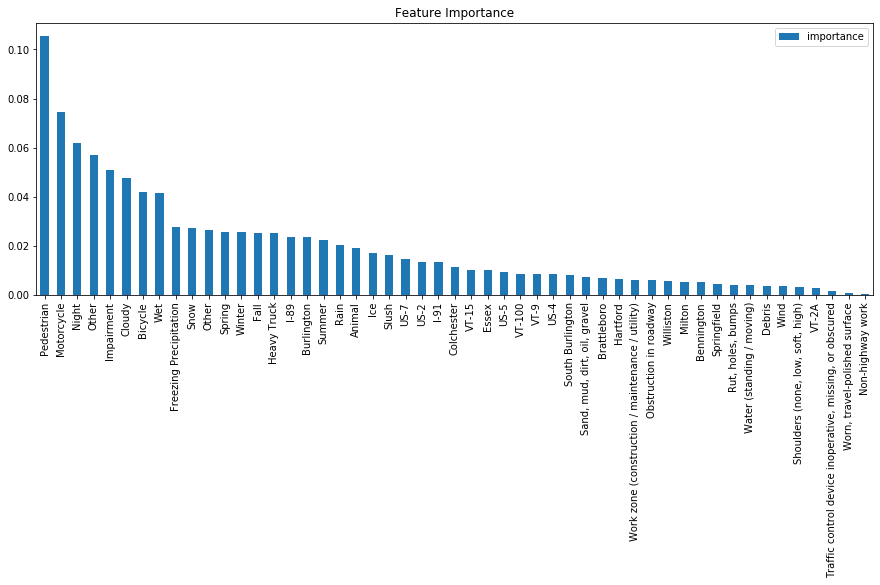

In [31]:
# Plot feature importances
feature_importances.plot(kind = 'bar',figsize=(15,5),
                         title='Feature Importance')

In [32]:
# Predict on test set
pred_y_rf = rf.predict(test_X)

In [33]:
from sklearn import metrics


def print_cm(cm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']] 
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

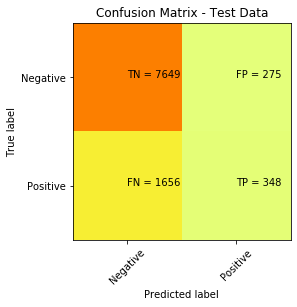

In [34]:
# Print confusion matrix
print_cm(metrics.confusion_matrix(test_y, pred_y_rf))

In [35]:
# Calculate classification accuracy
metrics.accuracy_score(test_y, pred_y_rf)

0.8054995970991137

In [36]:
# Calculate AUC
metrics.roc_auc_score(test_y, pred_y_rf)

0.5694740000060454

In [37]:
# Calculate Cohen's Kappa
metrics.cohen_kappa_score(test_y, pred_y_rf)

0.18711533034100591

In [38]:
# Print classification report
print(metrics.classification_report(test_y, pred_y_rf))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7924
           1       0.56      0.17      0.26      2004

    accuracy                           0.81      9928
   macro avg       0.69      0.57      0.58      9928
weighted avg       0.77      0.81      0.76      9928

